In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0


In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())


PyTorch version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1


In [3]:
import tensorflow as tf
print("CUDA Available:", tf.test.is_built_with_cuda())
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


CUDA Available: True
Num GPUs Available: 1


# Split the data

In [2]:
import os
import random
import shutil

train_images_folder = "C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-maiN/wildfire-detection-main/D-Fire/train/images"
train_labels_folder = "C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/D-Fire/train/labels"
val_images_folder = "C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/D-Fire/val/images"
val_labels_folder = "C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/D-Fire/val/labels"

# Create the validation folders if they don't exist
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)

# Filter only `.jpg` files (modify this part to exclude non-image files like .npy)
image_files = [f for f in os.listdir(train_images_folder) if f.endswith('.jpg')]

# Calculate the number of images to move to the validation set
num_val_images = int(0.1 * len(image_files))

# Randomly select the images to move
val_image_files = random.sample(image_files, num_val_images)

# Initialize counters for logging
moved_images = 0
moved_labels = 0
missing_labels = 0

# Move the selected images and their corresponding labels to the validation set
for image_file in val_image_files:
    # Move image file
    image_src = os.path.join(train_images_folder, image_file)
    image_dst = os.path.join(val_images_folder, image_file)
    shutil.move(image_src, image_dst)
    moved_images += 1

    # Move label file (if it exists)
    label_file = image_file.replace(".jpg", ".txt")
    label_src = os.path.join(train_labels_folder, label_file)
    label_dst = os.path.join(val_labels_folder, label_file)

    if os.path.exists(label_src):
        shutil.move(label_src, label_dst)
        moved_labels += 1
    else:
        missing_labels += 1
        print(f"Warning: Label file not found for {image_file}")

# Print a summary of the operation
print(f"\nSummary:")
print(f"Total images moved: {moved_images}")
print(f"Total labels moved: {moved_labels}")
print(f"Total missing labels: {missing_labels}")



Summary:
Total images moved: 826
Total labels moved: 826
Total missing labels: 0


# Create a configuration file

In [3]:
import yaml

# Define the configuration content
data_config = {
    'path': '/D-Fire',  # Root directory of the dataset
    'train': 'train/images',  # Relative path to the training images
    'val': 'val/images',  # Relative path to the validation images
    'test': 'test/images',  # Relative path to the test images
    'names': {
        0: 'smoke',  # Class ID 0
        1: 'fire'    # Class ID 1
    }
}

# Save the configuration to a YAML file
yaml_file_path = 'data.yaml'
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(data_config, yaml_file, default_flow_style=False)

print(f"Configuration file '{yaml_file_path}' created successfully!")


Configuration file 'data.yaml' created successfully!


In [4]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Should return your GPU name


True
1
NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
import torch

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [10]:
from PIL import Image
import os

def clean_corrupt_images(image_folder):
    """
    Checks all images in a folder and removes corrupt files.
    
    Args:
    image_folder (str): Path to the folder containing images.
    """
    total_files = 0
    removed_files = 0
    
    for root, _, files in os.walk(image_folder):
        for file in files:
            filepath = os.path.join(root, file)
            if filepath.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check image extensions
                total_files += 1
                try:
                    with Image.open(filepath) as img:
                        img.verify()  # Verify the image integrity
                except Exception as e:
                    print(f"Removing corrupt image: {filepath}")
                    os.remove(filepath)  # Remove the corrupt file
                    removed_files += 1
    
    print(f"Total files checked: {total_files}")
    print(f"Corrupt files removed: {removed_files}")

# Directories for your project
train_image_folder = "C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/D-Fire/train/images"
val_image_folder = "C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/D-Fire/val/images"

# Clean corrupt images in train and validation folders
print("Cleaning corrupt images in the training set...")
clean_corrupt_images(train_image_folder)

print("\nCleaning corrupt images in the validation set...")
clean_corrupt_images(val_image_folder)


Cleaning corrupt images in the training set...
Total files checked: 8262
Corrupt files removed: 0

Cleaning corrupt images in the validation set...
Total files checked: 8959
Corrupt files removed: 0


# Train the YOLOv8 Model

In [12]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')  # Use the nano model or any other version

# Training parameters
model.train(
    data='C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/data.yaml',  # Path to your dataset configuration file
    epochs=200,
    batch=16,
    imgsz=256,
    project='D-Fire-Detection',  # Project folder
    name='yolov8n-experiment',  # Experiment name
    device=0,  # Set to 0 for GPU, or 'cpu' for CPU
    amp=True,
    verbose=True,  # Ensure detailed logs
    resume=True  # Resume from last checkpoint
)


New https://pypi.org/project/ultralytics/8.3.68 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.136  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
c:\Users\ankit\anaconda3\envs\tensorflow_env\lib\site-packages\ultralytics\nn\tasks.py:561: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

AssertionError: yolov8n.pt training to 500 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=yolov8n.pt'

# Load model

In [2]:
from ultralytics import YOLO

try:
    model = YOLO("C:/Ankit/SERIOUS ARTICLES/VIT/EPICS PROJECT/machineLearning-main/machineLearning-main/wildfire-detection-main/final_model/best.pt")  # Replace with actual path
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)


Model loaded successfully!


c:\Users\ankit\anaconda3\envs\tensorflow_env\lib\site-packages\ultralytics\nn\tasks.py:561: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_locatio

In [12]:
results = model("C:/Users/ankit/Downloads/test.png")

print(results)  # This should print a list of 'Results' objects
print(type(results))  # Check the type of the results object



image 1/1 C:\Users\ankit\Downloads\test.png: 128x256 2 smokes, 1 fire, 119.5ms
Speed: 1.0ms preprocess, 119.5ms inference, 5.5ms postprocess per image at shape (1, 3, 128, 256)


[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'smoke', 1: 'fire'}
orig_img: array([[[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [216, 213, 208],
        [216, 214, 207],
        [216, 214, 207]],

       [[162, 162, 162],
        [162, 162, 162],
        [162, 162, 162],
        ...,
        [215, 214, 208],
        [216, 214, 207],
        [216, 214, 207]],

       [[166, 165, 166],
        [166, 165, 166],
        [166, 165, 166],
        ...,
        [215, 214, 208],
        [216, 214, 207],
        [216, 214, 207]],

       ...,

       [[ 43,  92, 147],
        [ 43,  91, 148],
        [ 40,  88, 149],
        ...,
        [ 36,  34,  32],
        [ 36,  34,  32],
        [ 36,  34,  32]],

       [[ 36,  89, 144],
        [ 37,  89, 144],
        [ 35,  86, 145],
        ...,
        [ 36,  34,  32],
        [ 36,  34,  3

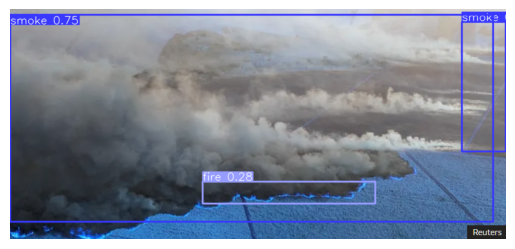

In [13]:
import matplotlib.pyplot as plt

# Get the first result
r = results[0]  

# Plot and display
img = r.plot()  # Get the annotated image
plt.imshow(img)
plt.axis("off")
plt.show()
plt.close()
